Все вычисления выполнены на AMD Ryzen 7 5800u с 8 ядрами

In [12]:
%%bash
gcc main.c -o main.so -fopenmp -lm -O0 -shared -fPIC

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
NUMBER_OF_EXPEREMENTS = 10
MAX_ITERATIONS_COUNT = 30000

In [15]:
MAX_BLOCK_SIZE = 40
BLOCK_STEP = 1
ERROR = 0.001
NET_SIZE = 25

In [16]:
def approximate(x, y):
    from scipy.interpolate import make_interp_spline, BSpline

    xnew = np.linspace(min(x), max(x), len(x) * 10)
    spl = make_interp_spline(x, y, k=3)
    power_smooth = spl(xnew)

    return xnew, power_smooth

In [17]:
def get_experiment_result(
    thread_count,
    approximate_error,
    absolute_error,
    block_size,
    net_size,
    k_param=100,
    function_number=1,
):
    from ctypes import CDLL, Structure, c_size_t, c_double

    so = CDLL("./main.so")

    class exec_res_t(Structure):
        _fields_ = [("number_of_iterations", c_size_t), ("total_time", c_double)]

    so.execute.restype = exec_res_t
    so.set_debug(0)
    so.set_iterations(MAX_ITERATIONS_COUNT)
    so.set_globals(
        c_size_t(thread_count),
        c_double(approximate_error),
        c_double(absolute_error),
        c_size_t(block_size),
        c_size_t(net_size),
        c_double(k_param),
    )
    res = so.execute(function_number)
    return (res.number_of_iterations, res.total_time)

Оценим как влияет размер блока на количество итераций и время выполнения.

Для этого переберем все размеры блока до MAX_BLOCK_SIZE с шагом BLOCK_STEP.

In [18]:
def calculate_mean_per_block_size(cpu_count, approximate_error=-1, absolute_error=-1):
    result_time = [[] for _ in range(0, MAX_BLOCK_SIZE, BLOCK_STEP)]
    result_iter = [[] for _ in range(0, MAX_BLOCK_SIZE, BLOCK_STEP)]

    for i in range(len(result_time)):
        for _ in range(NUMBER_OF_EXPEREMENTS):
            iter, time = get_experiment_result(
                cpu_count,
                approximate_error=approximate_error,
                absolute_error=absolute_error,
                block_size=i * BLOCK_STEP + 1,
                net_size=NET_SIZE,
            )
            result_time[i].append(time)
            result_iter[i].append(iter)

    for i in range(len(result_time)):
        result_time[i] = np.mean(result_time[i])
        result_iter[i] = np.mean(result_iter[i])
    return result_time, result_iter

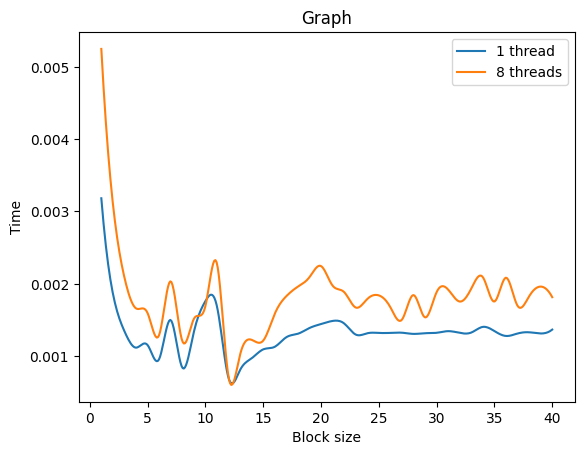

In [19]:
x_coords = [i * BLOCK_STEP + 1 for i in range(0, MAX_BLOCK_SIZE, BLOCK_STEP)]
y1_time, y1_iter = calculate_mean_per_block_size(1, approximate_error=ERROR)
y2_time, y2_iter = calculate_mean_per_block_size(8, approximate_error=ERROR)

plt.title("Graph")
plt.xlabel("Block size")
plt.ylabel("Time")

new_x, smooth_y1 = approximate(x_coords, y1_time)
plt.plot(new_x, smooth_y1, label="1 thread")
new_x, smooth_y2 = approximate(x_coords, y2_time)
plt.plot(new_x, smooth_y2, label="8 threads")
plt.legend()
plt.show()

Как видно из графика выше, BLOCK_SIZE <= 5 замедляет время выполнения до 5 раз.

Затем время выполнение асцилирует, пока не нормализируется, так как BLOCK_SIZE превосходит размер сетки и все вычисление происходит единым блоком.

При этом параллельный алгоритм на 8 потоков работает медленее, чем для одного. Это обусловлено высокими расходами на синхронизацию для небольшого размера сетки.

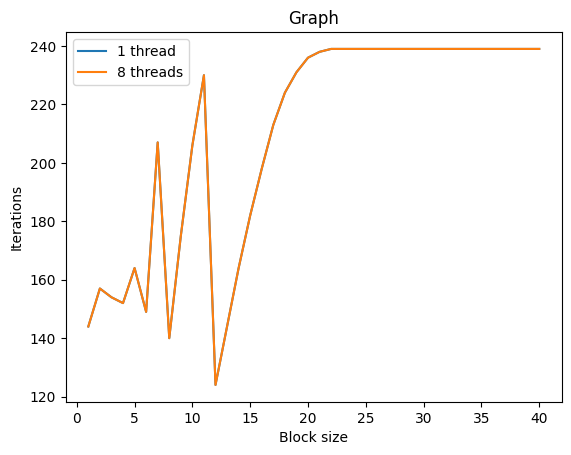

In [20]:
plt.title("Graph")
plt.xlabel("Block size")
plt.ylabel("Iterations")
plt.plot(x_coords, y1_iter, label="1 thread")
plt.plot(x_coords, y2_iter, label="8 threads")
plt.legend()
plt.show()

Гипотезу выше подтверждает этот график, так как количество итераций начиная с BLOCK_SIZE=25 одинаково.

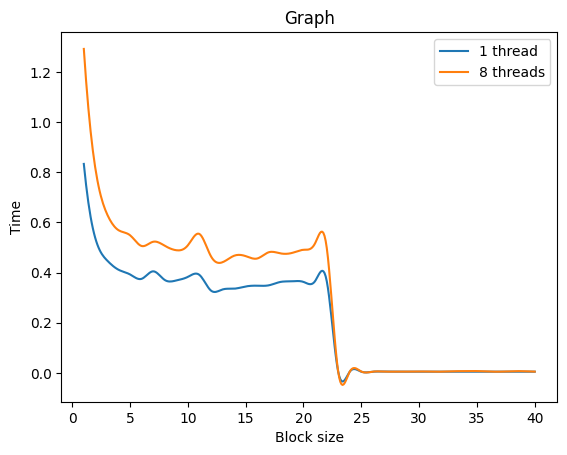

In [21]:
x_coords = [i * BLOCK_STEP + 1 for i in range(0, MAX_BLOCK_SIZE, BLOCK_STEP)]
y1_time, y1_iter = calculate_mean_per_block_size(1, absolute_error=ERROR)
y2_time, y2_iter = calculate_mean_per_block_size(8, absolute_error=ERROR)

plt.title("Graph")
plt.xlabel("Block size")
plt.ylabel("Time")
new_x, smooth_y1 = approximate(x_coords, y1_time)
plt.plot(new_x, smooth_y1, label="1 thread")
new_x, smooth_y2 = approximate(x_coords, y2_time)
plt.plot(new_x, smooth_y2, label="8 threads")
plt.legend()
plt.show()

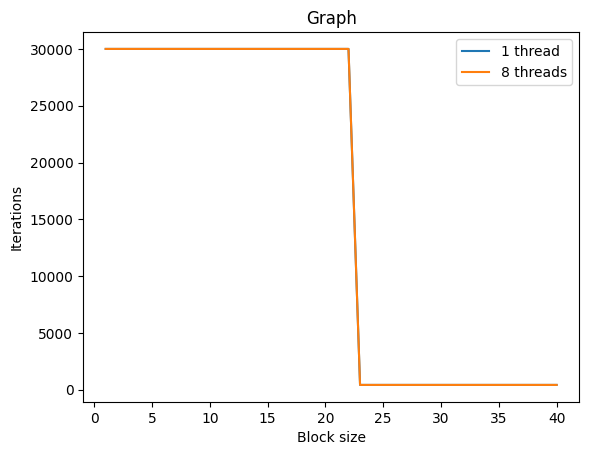

In [22]:
plt.title("Graph")
plt.xlabel("Block size")
plt.ylabel("Iterations")
plt.plot(x_coords, y1_iter, label="1 thread")
plt.plot(x_coords, y2_iter, label="8 threads")
plt.legend()
plt.show()

Даже при фиксированным количестве шагов время выполнения при BLOCK_SIZE <= 5 ведет себя так же как на графиках выше. А при BLOCK_SIZE > 25 количество итераций равно 1, так как не получается корректно посчитать ABSOLUTE_ERROR, так как BLOCK_SIZE > NET_SIZE.  

Рассмотрим функцию f(x, y) = (1 - 2 * y) * (1 - 2 * x)

[image-2.png](attachment:image-2.png)

Посмотрим, как скорость сходимости функции `g(x, y) = k*f(x, y)` изменяется при разных k.

In [23]:
MAX_K_VALUE = 1000000
K_STEP = 100000
BLOCK_SIZE = 32
NET_SIZE = 10
ERROR = 0.1

In [24]:
def calculate_mean_per_k(cpu_count, approximate_error=-1, absolute_error=-1):
    result_time = [[] for _ in range(0, MAX_K_VALUE, K_STEP)]
    result_iter = [[] for _ in range(0, MAX_K_VALUE, K_STEP)]

    for i in range(len(result_time)):
        for _ in range(NUMBER_OF_EXPEREMENTS):
            iter, time = get_experiment_result(
                cpu_count,
                approximate_error,
                absolute_error,
                BLOCK_SIZE,
                NET_SIZE,
                k_param=i * K_STEP,
                function_number=6,
            )
            result_time[i].append(time)
            result_iter[i].append(iter)

    for i in range(len(result_time)):
        result_time[i] = np.mean(result_time[i])
        result_iter[i] = np.mean(result_iter[i])
    return result_time, result_iter

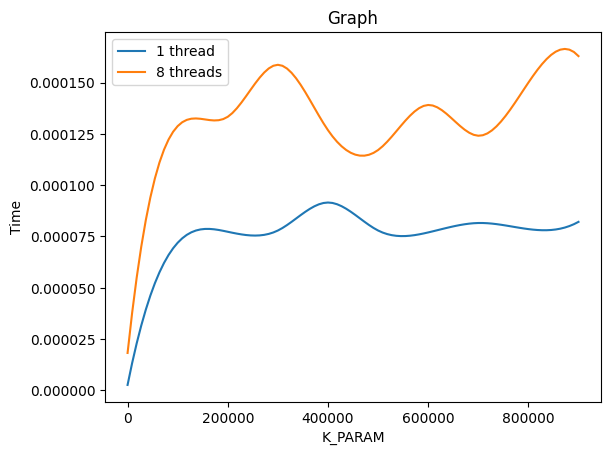

In [25]:
x_coords = [i for i in range(0, MAX_K_VALUE, K_STEP)]
y1_time, y1_iter = calculate_mean_per_k(1, approximate_error=ERROR)
y2_time, y2_iter = calculate_mean_per_k(8, approximate_error=ERROR)

plt.title("Graph")
plt.xlabel("K_PARAM")
plt.ylabel("Time")
new_x, smooth_y1 = approximate(x_coords, y1_time)
plt.plot(new_x, smooth_y1, label="1 thread")
new_x, smooth_y2 = approximate(x_coords, y2_time)
plt.plot(new_x, smooth_y2, label="8 threads")
plt.legend()
plt.show()

Аналогично предыдущему эксперименту алгоритм на 8 потоков медленнее на небольшой сетке.

А время растет логарифмически.

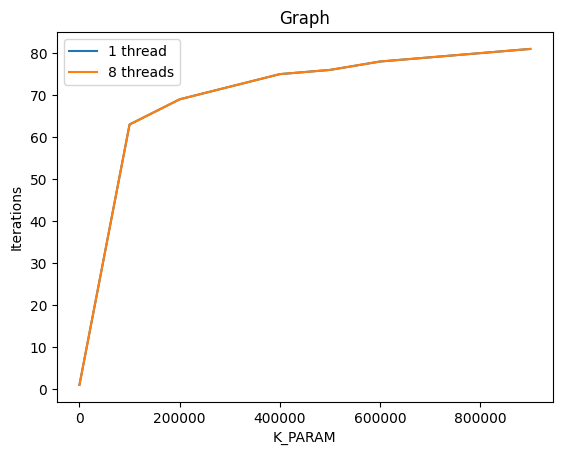

In [26]:
plt.title("Graph")
plt.xlabel("K_PARAM")
plt.ylabel("Iterations")
plt.plot(x_coords, y1_iter, label="1 thread")
plt.plot(x_coords, y2_iter, label="8 threads")
plt.legend()
plt.show()

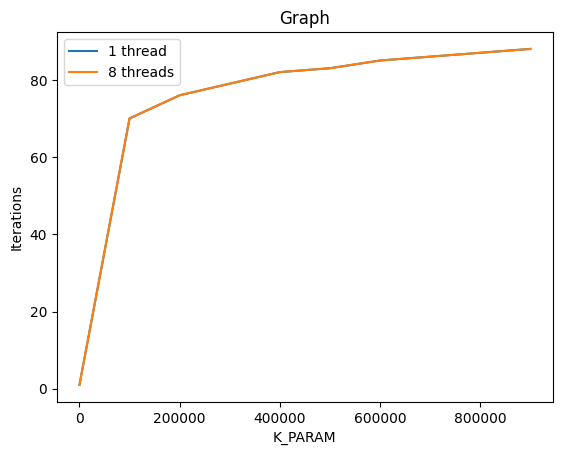

In [44]:
x_coords = [i for i in range(0, MAX_K_VALUE, K_STEP)]
y1_time, y1_iter = calculate_mean_per_k(1, absolute_error=ERROR)
y2_time, y2_iter = calculate_mean_per_k(8, absolute_error=ERROR)

plt.title("Graph")
plt.xlabel("K_PARAM")
plt.ylabel("Iterations")
plt.plot(x_coords, y1_iter, label="1 thread")
plt.plot(x_coords, y1_iter, label="8 threads")
plt.legend()
plt.show()

Количество итераций для абсолютной и относительной прогрешности растет тоже логарифмически

Таким образом, стоит выбирать значение BLOCK_SIZE от 5 до размера сетки, чтобы обеспечить корректное использование кеша.

Кроме того время выполнения и количество итераций приближения линейной функции зависит от коэффициента перед ней логарифмически.